In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%%capture
pip install rouge detoxify

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
%%capture
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

from detoxify import Detoxify

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.tokenize import word_tokenize


module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url, )
rouge = Rouge()

toxicity_models = {
    "original": Detoxify('original', device=device),
    # "unbiased": Detoxify('unbiased', device='cuda'),
    # "multilingual":Detoxify('multilingual', device='cuda')
}

print ("module %s loaded" % module_url)
def encode(input):
  return model(input)

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
from tqdm.auto import tqdm

def toxicity_score(sentences, model, key='toxicity'):
    return [toxicity_models[model].predict(x)[key] for x in tqdm(sentences)]

In [7]:
def use_score_pairs(left, right):
    return np.inner(encode(left), encode(right))

def plot_similarity(text, paratext, rotation=90):
    corr = score_pairs(text, paratext)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=paratext,
        yticklabels=text,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def bleu_score_pairs(left, right):
    left = map(word_tokenize, map(str.strip, map(str.lower, left)))
    right = map(word_tokenize, map(str.strip, map(str.lower, right)))
    return [sentence_bleu([x],y) for x,y in zip(left, right)]

def rouge_score_pairs(left, right):
    left = list(map(str.strip, map(str.lower, left)))
    right =  list(map(str.strip, map(str.lower, right)))
    rouge_scores =  rouge.get_scores(left, right)
    return [x['rouge-l']['f'] for x in rouge_scores]



In [8]:
import pandas as pd

In [9]:

#df = pd.read_csv("/gdrive/MyDrive/diploma/data/toxicity/jigsaw_toxic_full_paraphrased.csv", index_col=0)
df = pd.read_csv("/gdrive/MyDrive/diploma/data/metrics/output_data/mpc_paraphrase_GPT2.csv", index_col=0) #.sample(10000)

In [10]:
df1 = pd.read_csv("/gdrive/MyDrive/diploma/data/prepared_datasets/mpc.csv", index_col=0) #.sample(10000)

In [12]:
df1_set = set(df1['sentence1'])

In [15]:
df[(df['sentence1'].map(lambda x: x in df1_set)) | (df['sentence2'].map(lambda x: x in df1_set))]

,sentence1,sentence2,paraphrase
0,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi...","[""He accused his brother of deliberately disto..."
2,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an...","[""The cargo was published online June 10 from ..."
4,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...,"[""Shares of McDonald's rose $2.11, or about 11..."
5,Revenue in the first quarter of the year dropp...,With the scandal hanging over Stewart's compan...,"[""Operating revenue was $114.5 million, up 15 ..."
7,The DVD-CCA then appealed to the state Supreme...,The DVD CCA appealed that decision to the U.S....,"[""The DVD-CCA filed for chapter 11 bankruptcy ..."
...,...,...,...
5288,Remaining shares will be held by QVC's managem...,Members of the QVC management team hold the re...,"[""QVC has a 17.5 percent interest in QVC, whic..."
5289,The New York Yankees took third baseman Eric D...,"The Yankees selected Eric Duncan, a third base...","[""The New York Yankees selected third baseman ..."
5290,Gehring waived extradition Monday during a hea...,Gehring waived extradition Monday during a hea...,"[""Mr. Hring waived extradition Monday in San J..."
5293,"The deal, approved by both companies' board of...","After Hughes refused to rehire Hernandez, he c...","[""The acquisition is expected to close in the ..."


In [11]:
df1

,sentence1,sentence2
0,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
2,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
4,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...
5,Revenue in the first quarter of the year dropp...,With the scandal hanging over Stewart's compan...
7,The DVD-CCA then appealed to the state Supreme...,The DVD CCA appealed that decision to the U.S....
...,...,...
5792,Gehring waived extradition Monday during a hea...,Gehring waived extradition Monday during a hea...
5793,"""I am advised that certain allegations of crim...","""I am advised that certain allegations of crim..."
5795,"The deal, approved by both companies' board of...",The acquisition has been approved by both comp...
5799,"Last week the power station’s US owners, AES C...","The news comes after Drax's American owner, AE..."


In [ ]:
df.dropna(inplace=True)

In [ ]:
sentence

### Datasets tests

In [ ]:
orig = "sentence1"
for preds in ['sentence2']:
    # print("Use", preds)
    # use_pairs = use_score_pairs(df[orig], df[preds])
    # use_pairs = [use_pairs[i,i] for i in range(len(use_pairs))]
    # df['use'+"_"+preds] = use_pairs
    # print("Ngrams", preds)
    # df['bleu'+"_"+preds] = bleu_score_pairs(df[orig], df[preds])
    # df['rouge'+"_"+preds] = rouge_score_pairs(df[orig], df[preds])
    print("Toxicity", preds)
    df['tox_original'+"_"+preds] = toxicity_score(df[preds].tolist(), 'original')
print("Toxicity", orig)
df['tox_original'+"_"+orig] = toxicity_score(df[orig].tolist(), 'original')

Toxicity sentence2



Toxicity sentence1


In [ ]:
df

,sentence1,sentence2,tox_original_sentence2,tox_original_sentence1
15058,The lengthening often also applied in reverse ...,The lengthening often also applied in reverse ...,0.000633,0.000633
8137,Malik married businessman Asad Bashir Khan Kha...,Malik married businessman Asad Bashir Khan Kha...,0.000709,0.000675
42646,"At the age of nine , he appeared in his first ...","At the age of nine , Garcia appeared in his fi...",0.000774,0.000810
28479,Vladan Desnica ( ; 17 September 1905 -- 4 Marc...,"Vladan Desnica ( September 17 , 1905 - March 4...",0.000962,0.001123
2594,The Temple is widely perceived as well maintai...,The temple is commonly perceived as well organ...,0.000546,0.000540
...,...,...,...,...
35391,Sarons typically come in a number often sizes ...,"Typically , sarons in a number often come in s...",0.000698,0.000732
17730,In a letter to his friend Cicero stationed in ...,Trebatius Testa jokingly refers to `` andabata...,0.000668,0.000621
2483,It was rebuilt in 1940 during the Manchester f...,It was rebuilt and finally destroyed during th...,0.001205,0.000827
5064,Schliemann cleared five shafts and recognized ...,Schliemann cleared five shafts and recognized ...,0.000665,0.000656


In [ ]:
df['tox_original_sentence2'].mean(), df['tox_original_sentence1'].mean()

(0.0029339797192194966, 0.003017936488817213)

In [ ]:
print(f"USE: {df['use_sentence2'].mean()}\nBLEU: {df['bleu_sentence2'].mean()}\nROUGE: {df['rouge_sentence2'].mean()}\n Toxicity: {df['tox_original_sentence1'].mean()}")

USE: 0.8288323941618204
BLEU: 0.4383674951890858
ROUGE: 0.5575394075737561


In [ ]:
 df['use_sentence2'].median(), df['bleu_sentence2'].median(), df['rouge_sentence2'].median()

(0.8430193066596985, 0.4153509237206396, 0.5454545404958678)

### Continue

In [ ]:
round(0.91,1)

0.9

In [13]:
import json
df['paraphrase'] = df['paraphrase'].map(json.loads)

In [ ]:
df['paraphrase'] = df['paraphrase'].map(lambda x: x[0])

In [14]:
for i in range(10):
    df[i] = df['paraphrase'].map(lambda x: x[i])

In [16]:
orig = "sentence1"
for preds in range(10):
    print("__________________________", preds, "______________________________________")
    print("Use", preds)
    use_pairs = use_score_pairs(df[orig], df[preds])
    use_pairs = [use_pairs[i,i] for i in range(len(use_pairs))]
    df['use'+"_"+str(preds)] = use_pairs
    print("Ngrams", preds)
    df['bleu'+"_"+str(preds)] = bleu_score_pairs(df[orig], df[preds])
    df['rouge'+"_"+str(preds)] = rouge_score_pairs(df[orig], df[preds])
    print("Toxicity", preds)
    df['tox_original'+"_"+str(preds)] = toxicity_score(df[preds].tolist(), 'original')
print("Toxicity", orig)
df['tox_original'+"_"+orig] = toxicity_score(df[orig].tolist(), 'original')

__________________________ 0 ______________________________________
Use 0
Ngrams 0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


ValueError: ignored

In [ ]:
def reranking(row):
    i = [x for x in row.keys() if ("use_" in str(x)) and row[x]>0.7 ]
    i = i or [x[0] for x in sorted(filter(lambda x: "use_" in str(x[0]) ,row.items()), key=lambda x: x[1], reverse=True)[:3]]
    return [x[-1] for x in i]

import numpy as np
def lowest_tox(cols, row):
    return int(cols[np.argmin([row['tox_original_'+col] for col in cols])])
df['best'] = df.apply(lambda row: row[lowest_tox(reranking(row), row)], axis=1)

In [ ]:
df = df[['comment_text', 'best']]

In [24]:
orig = "ref_sent"
for preds in ['candidate']:
    print("Use", preds)
    use_pairs = use_score_pairs(df[orig], df[preds])
    use_pairs = [use_pairs[i,i] for i in range(len(use_pairs))]
    df['use'+"_"+preds] = use_pairs
    print("Ngrams", preds)
    df['bleu'+"_"+preds] = bleu_score_pairs(df[orig], df[preds])
    df['rouge'+"_"+preds] = rouge_score_pairs(df[orig], df[preds])
    print("Toxicity", preds)
    df['tox_original'+"_"+preds] = toxicity_score(df[preds].tolist(), 'original')
print("Toxicity", orig)
df['tox_original'+"_"+orig] = toxicity_score(df[orig].tolist(), 'original')

Use candidate
Ngrams candidate


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Toxicity candidate



Toxicity ref_sent


In [25]:
df

,candidate,ref_sent,use_candidate,bleu_candidate,rouge_candidate,tox_original_candidate,tox_original_ref_sent
5635,"That's Doug, not billiard.","That takes a crystal ball, Doug, not an eight ...",0.552936,0.198241,0.285714,0.003525,0.001365
3745,Lopinavir / ritonavir / Teno fovir disoproxil-...,Lopinavir/ritonavir/Tenofovir disoproxil fumar...,0.671937,0.267849,0.571429,0.001593,0.001591
3754,We couldn't ask the judge to delay because the...,We couldn't ask file Judge for a continuance b...,0.886950,0.384571,0.666667,0.000661,0.000657
3760,My brother's in the city sewer. He's also been...,My brother Jean- Robert works with the City Se...,0.659073,0.137162,0.363636,0.006603,0.005777
1256,No women would be anything.,There's nothing without a woman.,0.616320,0.540854,0.000000,0.347154,0.086118
...,...,...,...,...,...,...,...
16744,"from today, for ever.","Starting today, and for ever.",0.693993,0.503321,0.666667,0.000847,0.001037
19145,History will determine who the real patriots o...,History will judge who the true patriots were ...,0.789061,0.549100,0.476190,0.000746,0.001163
19862,Tom snorted in distaste and walked out.,Tom made a noise of disgust and left the room.,0.614333,0.537833,0.235294,0.011507,0.155440
15770,Let me see.,Let me check once again.,0.510485,0.428882,0.500000,0.000750,0.000639


In [19]:
df.to_csv("/gdrive/MyDrive/diploma/data/metrics/subs_metrics.csv")

In [ ]:
df = pd.read_csv("/gdrive/MyDrive/diploma/data/metrics/jigsaw_toxic_6k_paraphrased_with_GeDi_with_and_without_split_metrics.csv", index_col=0)

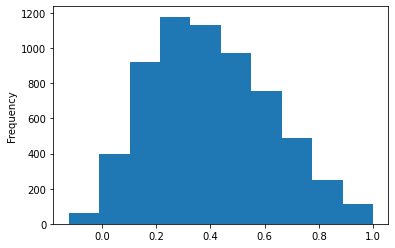

In [ ]:
df['use_preds'].plot(kind="hist")

In [ ]:
df

,orig,preds,preds_splitted,bleu_preds,rouge_preds,tox_original_preds,bleu_preds_splitted,rouge_preds_splitted,tox_original_preds_splitted,tox_original_orig,use_preds,use_preds_splitted
0,"Bye! Don't look, come or think of comming back...","Come, don't look at me like that. Tosser.",Leave me a message. Don 't look at me like tha...,0.276591,0.222222,0.584486,0.607680,0.000000,0.083630,0.814469,0.496570,0.260407
1,Stupid peace of shit stop deleting my stuff as...,Is there a way to get rid of an instagram acco...,Is there a way to get rid of an instagram acco...,0.558881,0.078431,0.000796,0.558881,0.078431,0.000796,0.996295,0.176693,0.176693
2,Hi! I am back again! Last warning! Stop undoin...,"Last time I did that, I died a few times. What...",Who invented the steam engine? Are you still h...,0.600964,0.125000,0.003088,0.000000,0.000000,0.000801,0.863642,0.336028,0.118693
3,"Would you both shut up, you don't run wikipedi...","You shut up, don't run Wikipedia and I can tel...","You shut up, don't run Wikipedia and I can tel...",0.195180,0.370370,0.997033,0.195180,0.370370,0.997033,0.964751,0.597887,0.597887
4,A pair of jew-hating weiner nazi schmucks.,"They call themselves the ""neo-nazi,"" a name wh...","They call themselves the ""neo-nazi,"" a name wh...",0.521695,0.080000,0.024797,0.521695,0.080000,0.024797,0.975069,0.154921,0.154921
...,...,...,...,...,...,...,...,...,...,...,...,...
6274,She's a little self obssessed and self righteo...,"That said, it's also true that she has a littl...",It's hard to say how much of a sociopathic per...,0.329651,0.160000,0.000631,0.674432,0.102564,0.001348,0.986637,0.299767,0.540690
6275,I will meet you one day and stab you to death ...,I will meet you one day and stabbed you to dea...,"One day, one shot. Help us, please block the I...",0.315811,0.607143,0.996799,0.115759,0.400000,0.000936,0.996519,0.786309,0.218683
6276,Oh that's not an airport...that's just where t...,That's not an airport... that's just where the...,"That's not an airport, it's a state of emergen...",0.212559,0.418605,0.000957,0.116915,0.297872,0.001009,0.924693,0.442489,0.339116
6277,That is because you are a retard. Business str...,"You were a baby sitter, now that's considered ...",You're a disgrace. It is possible the coins we...,0.077910,0.097561,0.942761,0.140059,0.357143,0.899619,0.958860,0.084123,0.617935


In [ ]:
df = df[df['use_preds']>=0.65]

In [ ]:
len(df)

933

In [ ]:
USE: 0.65
BLEU: 0.42
ROUGE-L: 0.44
Toxicity: 0.03

In [26]:
for x in df.columns:
    if x not in ['orig', 'preds', 'preds_splitted', 'comment_text', 'paraphrase', "best", 'sentence1', 'sentence2', 'ref_sent', 'candidate']:
        print(x, "mean", df[x].mean())
        print(x, "median", df[x].median())
        print(x, "min", df[x].min())
        print(x, "max", df[x].max())
        print("\n\n")


use_candidate mean 0.6500874374259729
use_candidate median 0.7054528594017029
use_candidate min -0.04853079468011856
use_candidate max 0.9785765409469604



bleu_candidate mean 0.425862138861765
bleu_candidate median 0.4025006760291232
bleu_candidate min 0.0
bleu_candidate max 0.9086549610666288



rouge_candidate mean 0.44992310636953264
rouge_candidate median 0.47619047124716557
rouge_candidate min 0.0
rouge_candidate max 0.9795918317367763



tox_original_candidate mean 0.03372373227175558
tox_original_candidate median 0.0007757005514577031
tox_original_candidate min 0.0005046389414928854
tox_original_candidate max 0.9958508014678955



tox_original_ref_sent mean 0.03493974939687178
tox_original_ref_sent median 0.0007558272336609662
tox_original_ref_sent min 0.0004973995382897556
tox_original_ref_sent max 0.9946604371070862





In [ ]:
i = 3177
print(df.loc[i, 'orig'])
print()
print(df.loc[i, 'preds'])
print()
print(df.loc[i, 'preds_splitted'])

I demand that you stop your trolling and personal attacks immediately!

You have to stop your trolling and personal attacks.

You have to stop your trolling and personal attacks.


0. говорим, что парафраз сильно зависит от качества текста
1. дать определение норм парафразу по метрикам

In [ ]:
pd.options.display.max_rows=200

In [ ]:
len(df)

6278

In [ ]:
182/6278

0.028990124243389613

In [ ]:
(df[(df['use_preds']>0.7) & (df['use_preds']<0.9) & ((df['tox_original_orig'] - df['tox_original_preds'])>0.2)][['orig', 'preds','preds_splitted', 'use_preds', 'use_preds_splitted', 'tox_original_preds', 'tox_original_preds_splitted', 'tox_original_orig']].sort_values("use_preds", ascending=False))

,orig,preds,preds_splitted,use_preds,use_preds_splitted,tox_original_preds,tox_original_preds_splitted,tox_original_orig
1671,"Idiot I deleted the comment ""Last years runner...","I deleted the comment ""Last years runners up C...","I deleted the comment ""Last years runners up C...",0.895440,0.895440,0.122884,0.122884,0.890010
2853,Current event? wtf is the current event about?,What is the current event about?,What is the significance of a major event in a...,0.895308,0.504447,0.000706,0.000616,0.587093
913,This page is full of psuedo-intellectual drive...,This page is full of PSO-itis. Zen karma. Genk...,This page is full of PSO-itis. Zen karma. Genk...,0.894977,0.894976,0.315202,0.315202,0.832840
5075,Study some linguistics before you say somethin...,Some linguistics before you say something idio...,Some linguistics before you say something idio...,0.892990,0.320027,0.551450,0.156547,0.857003
4287,"Hey, fuck you. That information was true, and ...","That information was true, and I don't see how...",You got what you deserved. I don't see how it'...,0.891231,0.506259,0.000774,0.001476,0.996696
3177,I demand that you stop your trolling and perso...,You have to stop your trolling and personal at...,You have to stop your trolling and personal at...,0.887323,0.887323,0.060822,0.060822,0.500026
1668,Are you nerds trying to get back for getting b...,Are you nerds trying to get back for getting b...,Are you guys still trying to get beat up? Why ...,0.885435,0.662693,0.722344,0.173996,0.944087
4509,"NO, i prefer, i will continue to attack Gerald...","i prefer, i will continue to attack Geraldo Pe...","i prefer, i will continue to attack Geraldo Pe...",0.882729,0.882729,0.048985,0.048985,0.985624
3606,Atheists HATE this guy How dare he attack thei...,Hate to break it to you but here goes: the ath...,Hate to break it to you but here goes: the ath...,0.880397,0.880397,0.686526,0.686526,0.933709
5788,So... where's Jazza and his footballing pigs?,Where's Jazza and his football pigs?,Who is going to win in the general elections i...,0.880158,0.415712,0.337106,0.001251,0.681557


In [ ]:
len(df[(df['use_preds']<0.9) & (df['use_preds']>0.7) ][['orig', 'preds','preds_splitted', 'use_preds', 'use_preds_splitted', 'tox_original_preds', 'tox_original_preds_splitted', 'tox_original_orig']].sort_values("use_preds", ascending=False))

573

In [ ]:
df[df['use_preds']<0.9][['orig', 'preds','preds_splitted', 'use_preds', 'use_preds_splitted', 'tox_original_preds', 'tox_original_preds_splitted', 'tox_original_orig']].sort_values("use_preds", ascending=False).iloc[:100]

,orig,preds,preds_splitted,use_preds,use_preds_splitted,tox_original_preds,tox_original_preds_splitted,tox_original_orig
315,Yay! Now I'll have time to go work on my dream...,Now I will have time to go work on my dream of...,Happy! I will have time to go work on my dream...,0.899835,0.746172,0.965756,0.877878,0.972361
1785,What the fuck. Really? Blackmetalbaz comes to ...,Black metalbaz comes to MY talk page and provo...,What is the matter with me? What is the differ...,0.898235,0.405524,0.998236,0.288832,0.998367
4344,I suggest you kill yourself.,You want to kill yourself?,You want to kill yourself?,0.897489,0.897489,0.925007,0.925007,0.895521
4527,"Well, you might not be welcoming me if you kne...",You might not be welcome in my party if you kn...,"If you don 't welcome me in here, I will polit...",0.895982,0.478526,0.159021,0.135122,0.172369
1671,"Idiot I deleted the comment ""Last years runner...","I deleted the comment ""Last years runners up C...","I deleted the comment ""Last years runners up C...",0.895440,0.895440,0.122884,0.122884,0.890010
3509,Can't you at least have the common courtesy to...,Do you have the common courtesy to answer my q...,Do you have the common courtesy to answer my q...,0.895407,0.895407,0.705988,0.705988,0.774080
2853,Current event? wtf is the current event about?,What is the current event about?,What is the significance of a major event in a...,0.895308,0.504447,0.000706,0.000616,0.587093
913,This page is full of psuedo-intellectual drive...,This page is full of PSO-itis. Zen karma. Genk...,This page is full of PSO-itis. Zen karma. Genk...,0.894977,0.894976,0.315202,0.315202,0.832840
2923,Thank you for being such a politically correct...,Thanks for being such a politically correct ba...,Thanks for getting all upset over politics! Wh...,0.894652,0.545263,0.997168,0.994434,0.996159
2830,Newsflash! Schuminweb is GAY!,Schuminweb is gay.,Where can I watch the latest episodes of Flash...,0.893839,0.239925,0.930599,0.084933,0.915570


In [ ]:
len(df)

6278

In [ ]:
df[['orig', 'preds','preds_splitted', 'use_preds', 'use_preds_splitted', 'tox_original_preds', 'tox_original_preds_splitted', 'tox_original_orig']].median()

use_preds                      0.384413
use_preds_splitted             0.404743
tox_original_preds             0.026724
tox_original_preds_splitted    0.056683
tox_original_orig              0.963898
dtype: float64

In [ ]:
df['bleu'] = bleu_score_pairs(df['original'], df['paraphrase'])
df['rouge'] = rouge_score_pairs(df['original'], df['paraphrase'])

KeyError: ignored

In [ ]:
for i, x in df.sort_values('use', ascending=False).iloc[500:600].iterrows():
    print(x['original'])
    print()
    print(x['paraphrase'])
    print(x['use'], x['bleu'], x['rouge'])
    print("-"*70)

OH SHUT UP YOU FUCCIN ASSHOLE! ( )

SHUT UP YOU BASTARDSHOLE!<|endoftext|>
0.6623361706733704 0.34665771270955187 0.49999999555555563
----------------------------------------------------------------------
BITCH Your a bitch! Why did you delete the English Way page?

Why did you delete the englishway?<|endoftext|>
0.6610419750213623 0.27559110500755524 0.5555555511111112
----------------------------------------------------------------------
Current Squad No FOOKIN AROUND WITH IT, alright!

Squad No Fookin 'Around' Squad is back with more action than ever.<|endoftext|>
0.6607799530029297 0.22089591134157885 0.39999999520000007
----------------------------------------------------------------------
worm. Who agree with me? Leave Allen alone will ya

Leave Allen alone, please."<|endoftext|>
0.6604874134063721 0.2658156069371863 0.2666666622222223
----------------------------------------------------------------------
this fucking wikipedia forever

Will Wikipedia become just like Wikipedia?
